# Using Python to Access CWB Radar Image & Plotting Azimuths w.r.t. Radar Location.

**This notebook pulls the CWB latest radar image from https://www.cwb.gov.tw/V8/C/W/OBS_Radar.html, and plot azimuths from the planned S-PolKa radar location.**

In [54]:
%reset

import datetime
import pytz
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.geodesic as cgds
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import shapely
from pyproj import Geod
# from PIL import Image

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Functions for time retrieving:

In [55]:
def timeround10(dt):
    # a, b = divmod(round(dt.minute, -1), 60)
    a, b = divmod(math.floor(dt.minute * 0.1)/0.1, 60)
    # return '%i:%02i' % ((dt.hour + a) % 24, b)
    print(b)
    return datetime.datetime(dt.year, dt.month, dt.day, int((dt.hour + a) % 24), int(b), 0, 0) 

def timeround10before(tm):
    tm = tm - datetime.timedelta(minutes=tm.minute % 10, seconds=tm.second, microseconds=tm.microsecond)
    return tm


## Retrieve the latest radar image form CWB and generate one test plot:
**Choose between two different CWB map types ('L'arge area / 'C'oncentrate to Taiwan) \
and w/wo topography (wo:1 / w:2).**

Current time unavailable. Try 10-min before:
https://www.cwb.gov.tw/Data/radar/CV1_3600_202108110150.png


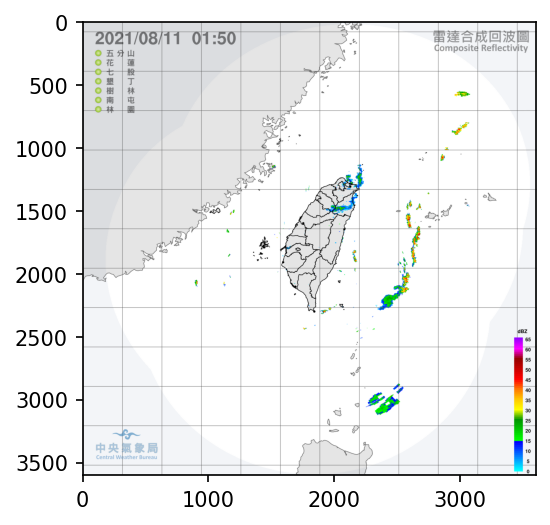

In [56]:
map_type = 'L'
map_topo = '1'

def map_selection(map_type, map_topo):
    if ( map_type == 'C' ):
        radar_img_url_name = 'https://www.cwb.gov.tw/Data/radar/CV' + map_topo + '_TW_3600_'
    elif ( map_type == 'L' ):
        radar_img_url_name = 'https://www.cwb.gov.tw/Data/radar/CV' + map_topo + '_3600_'
    return radar_img_url_name
        
radar_img_url_name = map_selection(map_type, map_topo)
    
try:
    radar_img_time = timeround10before(datetime.datetime.now(pytz.timezone('Asia/Taipei'))).strftime('%Y%m%d%H%M')
    radar_img_url = radar_img_url_name + radar_img_time + '.png'
    radar_img = plt.imread(radar_img_url)
    print(radar_img_url)
except:
    print('Current time unavailable. Try 10-min before:')
    radar_time = datetime.datetime.now(pytz.timezone('Asia/Taipei')) - datetime.timedelta(minutes=10)
    radar_img_time = timeround10before(radar_time).strftime('%Y%m%d%H%M')
    radar_img_url = radar_img_url_name + radar_img_time + '.png'
    radar_img = plt.imread(radar_img_url)
    print(radar_img_url)

# print(radar_image)

plt.figure(figsize=(4, 4), dpi=150)
plt.imshow(radar_img)
plt.show()


## Function generating maps and azimuth rings:

In [67]:
def new_map(fig, lon, lat, azimuths):
    
    # Create projection centered as the CWB radar image:
    # proj = ccrs.LambertConformal(central_longitude=121.0, central_latitude=23.5)
    proj = ccrs.PlateCarree()

    # New axes with the specified projection:
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    # Add coastlines:
    ax.coastlines('10m', 'black', linewidth=2, zorder=10)
    
    # Set extent the same as CWB radar image:
    if ( map_type == 'C' ):
        ax.set_extent([117.75, 124.25, 20.25, 26.75])
    elif ( map_type == 'L' ):
        ax.set_extent([114.75, 126.75, 17.5, 29.5])

    # Add grid lines & labels:
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.left_labels = False
    gl.xlines = False
    gl.ylines = False
    if ( map_type == 'L' ):
        gl.xlocator = plticker.FixedLocator(np.arange(115, 126.5, 1))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 14, 'weight': 'bold'}
    gl.ylabel_style = {'size': 14, 'weight': 'bold'}
    
    # Add star at the location of the radar:
    # lat_SPOL_HC = 24.820
    # lon_SPOL_HC = 120.908
    ax.scatter(lon, lat, marker='*', s=100, color='k', transform=ccrs.PlateCarree())

    # Add a ring at ~50 km from tha radar:
    circle_points = cgds.Geodesic().circle(lon=lon, lat=lat, radius=50000, n_samples=100, endpoint=False)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='red', linewidth=2)

    # Add a ring at ~100 km from tha radar:
    circle_points = cgds.Geodesic().circle(lon=lon, lat=lat, radius=100000, n_samples=100, endpoint=False)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='red', linewidth=2)
    
    # Add a ring at ~150 km from tha radar:
    circle_points = cgds.Geodesic().circle(lon=lon, lat=lat, radius=150000, n_samples=100, endpoint=False)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='red', linewidth=2)

    # Add a ring at ~200 km from tha radar:
    circle_points = cgds.Geodesic().circle(lon=lon, lat=lat, radius=200000, n_samples=100, endpoint=False)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='red', linewidth=2)
    
    # Line points at azimuths:
    geod = Geod(ellps='clrk66')
    rng = 200 * 1000
    for az in azimuths:
        lon2, lat2, _ = geod.fwd(lon, lat, az, rng)
        ax.plot([lon, lon2],[lat, lat2], '--k', transform=ccrs.PlateCarree(), linewidth=1)
        ax.text(lon2, lat2, az, transform=ccrs.PlateCarree())
    
    return ax

## Generate the scan map:

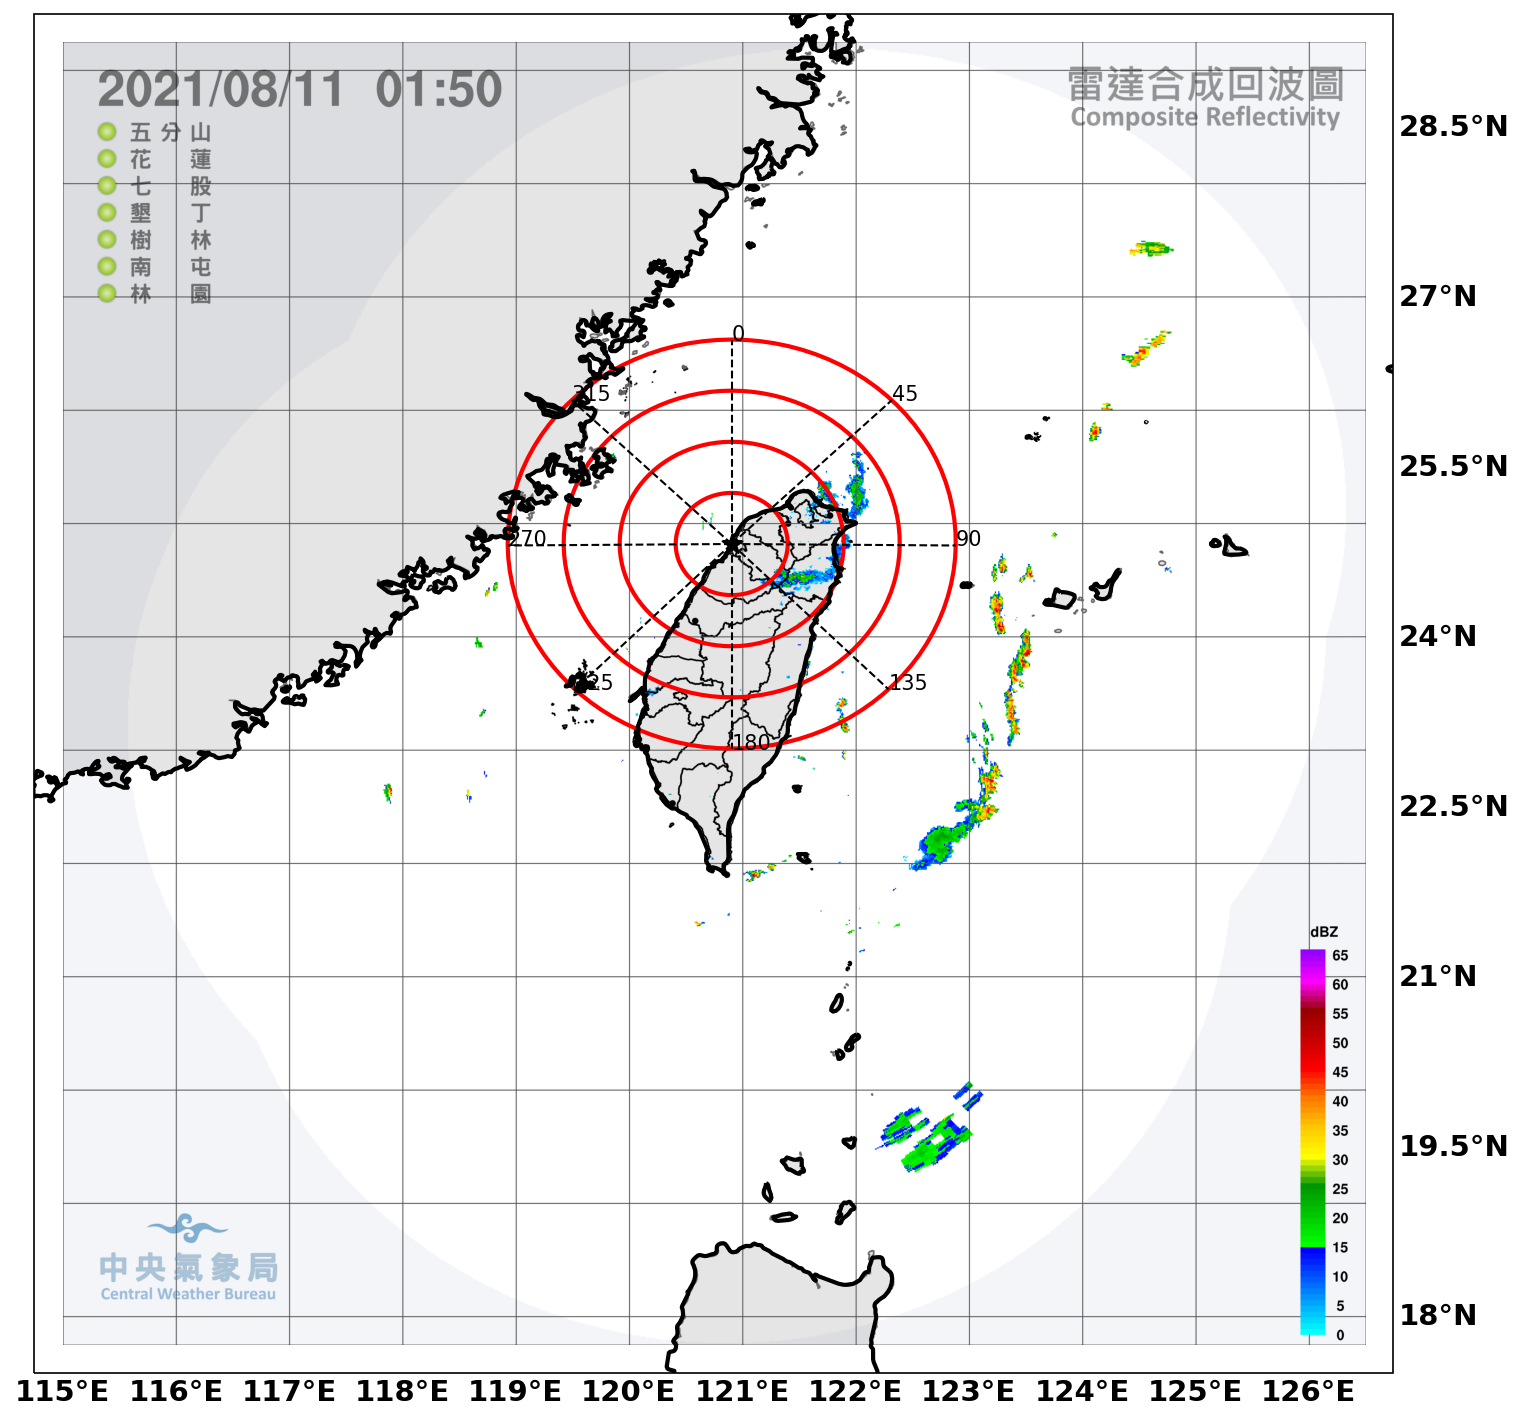

In [68]:
fig = plt.figure(figsize=(12, 12), dpi=150)

az = [0, 45, 90, 135, 180, 225, 270, 315]
# az = np.arange(240, 306, 5)
# az = [250, 262, 274, 286, 298, 310, 322, 334, 346, 358, 10, 22, 34, 46, 58, 70]

ax = new_map(fig, 120.908, 24.820, az)

if ( map_type == 'C' ):
    img_extent = (118, 124, 20.5, 26.5)
elif( map_type == 'L' ):
    img_extent = (115, 126.5, 17.75, 29.25)

plt.imshow(radar_img, extent=img_extent, zorder=0, transform=ccrs.PlateCarree())
# plt.show()

plt.savefig('./PRECIP_2022_CWB+SPOL_with200kmring_and_azimuths.png', bbox_inches='tight')